### Import Libraries

In [1]:
import os
import cv2
import copy
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
random_seed = 42
torch.manual_seed(random_seed);

In [4]:
torch.set_printoptions(edgeitems=5)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()

In [7]:
device

device(type='cuda')

### Step 1a) Fetch the LFW dataset

In [8]:
main_dir = '../datasets/LFW' #For Ubuntu
#main_dir = 'D:/Face/LFW' #For Windows
data_dir = main_dir + "/lfw-deepfunneled/lfw-deepfunneled"

print(os.listdir(main_dir))
classes = os.listdir(data_dir)
print(len(classes))

['people.csv', 'lfw_readme.csv', 'pairs.csv', 'matchpairsDevTest.csv', 'lfw-deepfunneled', 'peopleDevTest.csv', 'matchpairsDevTrain.csv', 'peopleDevTrain.csv', 'mismatchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'lfw_allnames.csv']
5749


In [9]:
img_Aaron_Eckhart = os.listdir(data_dir + "/Aaron_Eckhart")
print('No. of training examples for Aaron_Eckhart:', len(img_Aaron_Eckhart))
print(img_Aaron_Eckhart[:])

No. of training examples for Aaron_Eckhart: 1
['Aaron_Eckhart_0001.jpg']


In [10]:
dataset = ImageFolder(data_dir, transform=ToTensor())

In [11]:
len(dataset)

13233

In [12]:
print(dataset.classes)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

### Step 1b) Visualize the dataset

In [13]:
img, label = dataset[13232]
print(img.shape, label)

torch.Size([3, 250, 250]) 5748


Text(0.5, 1.0, 'label = 5748')

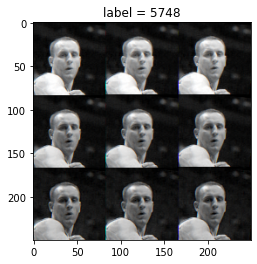

In [14]:
img, label = dataset[13232]
img = torch.reshape(img, (250, 250, 3))

plt.imshow(img)
plt.title('label = ' + str(label))

### Step 1c) Split the dataset into training, validation, and testing

In [15]:
test_factor = 0.1
test_size = int(test_factor * len(dataset))
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(dataset))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(10587, 1323, 1323)

In [17]:
batch_size=128

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [20]:
len(train_dl), len(val_dl), len(test_dl)

(83, 11, 11)

### Step 2a) Model Architecture - Network

In [21]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [22]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [23]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [24]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [25]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [26]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten()]
        self.fc = nn.Linear(n_channels[n_groups]*2, n_classes)
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        temp = self.features(x)
        return self.fc(temp)

In [27]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [28]:
#model = ResNet50(85742)

In [29]:
loaded_model = ResNet50(85742)
to_device(loaded_model, device)

MyResNet(
  (fc): Linear(in_features=2048, out_features=85742, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), s

In [30]:
#loaded_model.load_state_dict(torch.load("training/el_2epoch_70acc.pth"))
loaded_model.load_state_dict(torch.load("training/el_15epoch_92acc.pth"))

<All keys matched successfully>

In [31]:
summary(loaded_model, input_size = (3, 250, 250), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
            Conv2d-4          [-1, 256, 63, 63]          16,384
            Conv2d-5           [-1, 64, 63, 63]           4,096
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]          16,384
         ResBlock-12          [-1, 256, 63, 63]               0
      BatchNorm2d-13          [-1, 256, 63, 63]             512
           Conv2d-14           [-1, 64,

In [32]:
#model.layers

In [33]:
#model = ResNet50(85742)

for param in loaded_model.parameters():
    param.requires_grad = False
    #print(param.shape)
    #print('----------------------------')
    #model.fc = nn.Linear(5749, 8)
    #print("After addition: ", param.shape)

In [34]:
del loaded_model.fc

In [35]:
loaded_model.fc = nn.Linear(2048, 5749)

In [36]:
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [37]:
summary(loaded_model, input_size = (3, 250, 250), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
            Conv2d-4          [-1, 256, 63, 63]          16,384
            Conv2d-5           [-1, 64, 63, 63]           4,096
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]          16,384
         ResBlock-12          [-1, 256, 63, 63]               0
      BatchNorm2d-13          [-1, 256, 63, 63]             512
           Conv2d-14           [-1, 64,

### Step 2b) Loss Function

In [38]:
loss_Function = F.cross_entropy #CosFace() #

### Step 3) Training the model

In [39]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    preds = model(xb)
    #Generate probabilities
    #preds = F.softmax(preds, dim=1)
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #update parameters
        opt.step()
        #Reset Gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
    
    #print(loss.is_cuda)
    #print(xb.is_cuda)
    #print(metric_result.is_cuda)
        
    return loss.item(), len(xb), metric_result

In [40]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [41]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    #opt = opt_fn(model.parameters(), lr=lr)
    opt = opt_fn(model.fc.parameters(), lr=lr)
    
    for epoch in range(epochs):
        start = time.time()
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
            print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            print(str(round((end - start), 2)) + " secs")

    return train_losses, val_losses, val_metrics

In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [43]:
val_loss, _, val_acc = evaluate(loaded_model, loss_Function, val_dl, metric=accuracy) #metric=accuracy #metric=None

In [44]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))
#print('Loss: {:.4f}'.format(val_loss))

Loss: 8.6554, Accuracy: 0.0000


In [45]:
num_epochs = 2000
opt_func = torch.optim.Adam
lr = 0.05

In [46]:
history = fit(num_epochs, loaded_model, loss_Function, train_dl, val_dl, lr, accuracy, opt_func)

Epoch [1/2000], Train_loss: 8.5729, Val_loss: 7.9038, accuracy: 0.2071
21.18 secs
Epoch [2/2000], Train_loss: 3.9902, Val_loss: 7.4719, accuracy: 0.3054
26.97 secs
Epoch [3/2000], Train_loss: 1.2776, Val_loss: 7.1250, accuracy: 0.3416
26.22 secs
Epoch [4/2000], Train_loss: 0.5254, Val_loss: 6.9360, accuracy: 0.3598
26.21 secs
Epoch [5/2000], Train_loss: 0.2176, Val_loss: 6.9979, accuracy: 0.3583
26.62 secs
Epoch [6/2000], Train_loss: 0.1919, Val_loss: 7.0002, accuracy: 0.3651
25.22 secs
Epoch [7/2000], Train_loss: 0.1287, Val_loss: 7.0135, accuracy: 0.3719
26.55 secs
Epoch [8/2000], Train_loss: 0.0893, Val_loss: 6.9954, accuracy: 0.3673
26.33 secs
Epoch [9/2000], Train_loss: 0.0736, Val_loss: 7.0047, accuracy: 0.3726
26.46 secs
Epoch [10/2000], Train_loss: 0.0729, Val_loss: 7.0179, accuracy: 0.3681
26.5 secs
Epoch [11/2000], Train_loss: 0.0737, Val_loss: 7.0327, accuracy: 0.3711
25.4 secs
Epoch [12/2000], Train_loss: 0.0350, Val_loss: 7.0197, accuracy: 0.3696
26.55 secs
Epoch [13/2000]

Epoch [101/2000], Train_loss: 0.0005, Val_loss: 7.1490, accuracy: 0.3923
26.65 secs
Epoch [102/2000], Train_loss: 0.0003, Val_loss: 7.1578, accuracy: 0.3961
26.55 secs
Epoch [103/2000], Train_loss: 0.0003, Val_loss: 7.1818, accuracy: 0.3946
25.42 secs
Epoch [104/2000], Train_loss: 0.0004, Val_loss: 7.1755, accuracy: 0.3976
26.54 secs
Epoch [105/2000], Train_loss: 0.0002, Val_loss: 7.1652, accuracy: 0.3953
25.44 secs
Epoch [106/2000], Train_loss: 0.0002, Val_loss: 7.1335, accuracy: 0.3961
26.57 secs
Epoch [107/2000], Train_loss: 0.0006, Val_loss: 7.1785, accuracy: 0.3983
26.48 secs
Epoch [108/2000], Train_loss: 0.0001, Val_loss: 7.1476, accuracy: 0.3983
25.48 secs
Epoch [109/2000], Train_loss: 0.0002, Val_loss: 7.1773, accuracy: 0.3961
26.58 secs
Epoch [110/2000], Train_loss: 0.0003, Val_loss: 7.1655, accuracy: 0.3946
25.44 secs
Epoch [111/2000], Train_loss: 0.0002, Val_loss: 7.1737, accuracy: 0.3976
26.58 secs
Epoch [112/2000], Train_loss: 0.0002, Val_loss: 7.1651, accuracy: 0.3991
26.

Epoch [199/2000], Train_loss: 0.0000, Val_loss: 8.0465, accuracy: 0.3946
26.54 secs
Epoch [200/2000], Train_loss: 0.0000, Val_loss: 8.0271, accuracy: 0.3938
25.44 secs
Epoch [201/2000], Train_loss: 0.0000, Val_loss: 8.0474, accuracy: 0.3923
26.56 secs
Epoch [202/2000], Train_loss: 0.0000, Val_loss: 8.0599, accuracy: 0.3938
25.43 secs
Epoch [203/2000], Train_loss: 0.0000, Val_loss: 8.0521, accuracy: 0.3938
26.55 secs
Epoch [204/2000], Train_loss: 0.0000, Val_loss: 8.0829, accuracy: 0.3961
26.56 secs
Epoch [205/2000], Train_loss: 0.0000, Val_loss: 8.0551, accuracy: 0.3946
25.69 secs
Epoch [206/2000], Train_loss: 0.0000, Val_loss: 8.0478, accuracy: 0.3961
26.57 secs
Epoch [207/2000], Train_loss: 0.0000, Val_loss: 8.0745, accuracy: 0.3946
25.37 secs
Epoch [208/2000], Train_loss: 0.0000, Val_loss: 8.0589, accuracy: 0.3968
26.47 secs
Epoch [209/2000], Train_loss: 0.0000, Val_loss: 8.0877, accuracy: 0.3953
26.54 secs
Epoch [210/2000], Train_loss: 0.0000, Val_loss: 8.0727, accuracy: 0.3953
25.

Epoch [297/2000], Train_loss: 0.0000, Val_loss: 8.3329, accuracy: 0.3900
25.47 secs
Epoch [298/2000], Train_loss: 0.0000, Val_loss: 8.3480, accuracy: 0.3953
26.47 secs
Epoch [299/2000], Train_loss: 0.0000, Val_loss: 8.3317, accuracy: 0.3946
25.39 secs
Epoch [300/2000], Train_loss: 0.0000, Val_loss: 8.3478, accuracy: 0.3938
26.59 secs
Epoch [301/2000], Train_loss: 0.0000, Val_loss: 8.3406, accuracy: 0.3938
26.53 secs
Epoch [302/2000], Train_loss: 0.0000, Val_loss: 8.3304, accuracy: 0.3930
25.52 secs
Epoch [303/2000], Train_loss: 0.0000, Val_loss: 8.3430, accuracy: 0.3946
26.65 secs
Epoch [304/2000], Train_loss: 0.0000, Val_loss: 8.3313, accuracy: 0.3953
25.35 secs
Epoch [305/2000], Train_loss: 0.0000, Val_loss: 8.3565, accuracy: 0.3946
26.63 secs
Epoch [306/2000], Train_loss: 0.0000, Val_loss: 8.3372, accuracy: 0.3961
26.44 secs
Epoch [307/2000], Train_loss: 0.0000, Val_loss: 8.3399, accuracy: 0.3946
25.88 secs
Epoch [308/2000], Train_loss: 0.0000, Val_loss: 8.3229, accuracy: 0.3961
26.

Epoch [395/2000], Train_loss: 0.0000, Val_loss: 8.7182, accuracy: 0.3938
26.49 secs
Epoch [396/2000], Train_loss: 0.0000, Val_loss: 8.7118, accuracy: 0.3946
25.41 secs
Epoch [397/2000], Train_loss: 0.0000, Val_loss: 8.7069, accuracy: 0.3930
26.49 secs
Epoch [398/2000], Train_loss: 0.0000, Val_loss: 8.7035, accuracy: 0.3930
26.04 secs
Epoch [399/2000], Train_loss: 0.0000, Val_loss: 8.7124, accuracy: 0.3938
26.01 secs
Epoch [400/2000], Train_loss: 0.0000, Val_loss: 8.7142, accuracy: 0.3915
26.52 secs
Epoch [401/2000], Train_loss: 0.0000, Val_loss: 8.7018, accuracy: 0.3946
25.37 secs
Epoch [402/2000], Train_loss: 0.0000, Val_loss: 8.7029, accuracy: 0.3938
26.52 secs
Epoch [403/2000], Train_loss: 0.0000, Val_loss: 8.7053, accuracy: 0.3953
25.93 secs
Epoch [404/2000], Train_loss: 0.0000, Val_loss: 8.7247, accuracy: 0.3946
26.0 secs
Epoch [405/2000], Train_loss: 0.0000, Val_loss: 8.7037, accuracy: 0.3923
26.54 secs
Epoch [406/2000], Train_loss: 0.0000, Val_loss: 8.6923, accuracy: 0.3953
25.3

Epoch [493/2000], Train_loss: 0.0000, Val_loss: 8.6520, accuracy: 0.4006
25.39 secs
Epoch [494/2000], Train_loss: 0.0000, Val_loss: 8.6395, accuracy: 0.3976
26.57 secs
Epoch [495/2000], Train_loss: 0.0000, Val_loss: 8.6929, accuracy: 0.4006
26.33 secs
Epoch [496/2000], Train_loss: 0.0000, Val_loss: 8.6562, accuracy: 0.3998
26.44 secs
Epoch [497/2000], Train_loss: 0.0000, Val_loss: 8.6652, accuracy: 0.3961
26.65 secs
Epoch [498/2000], Train_loss: 0.0000, Val_loss: 8.6366, accuracy: 0.3983
25.39 secs
Epoch [499/2000], Train_loss: 0.0000, Val_loss: 8.6574, accuracy: 0.4006
26.59 secs
Epoch [500/2000], Train_loss: 0.0000, Val_loss: 8.6459, accuracy: 0.3991
25.98 secs
Epoch [501/2000], Train_loss: 0.0000, Val_loss: 8.6533, accuracy: 0.4006
26.65 secs
Epoch [502/2000], Train_loss: 0.0000, Val_loss: 8.6462, accuracy: 0.4006
26.46 secs
Epoch [503/2000], Train_loss: 0.0000, Val_loss: 8.6463, accuracy: 0.4006
25.43 secs
Epoch [504/2000], Train_loss: 0.0000, Val_loss: 8.6699, accuracy: 0.3983
26.

Epoch [591/2000], Train_loss: 0.0000, Val_loss: 8.9528, accuracy: 0.3915
26.59 secs
Epoch [592/2000], Train_loss: 0.0000, Val_loss: 8.9514, accuracy: 0.3908
25.81 secs
Epoch [593/2000], Train_loss: 0.0000, Val_loss: 8.9580, accuracy: 0.3900
26.48 secs
Epoch [594/2000], Train_loss: 0.0000, Val_loss: 8.9692, accuracy: 0.3893
26.58 secs
Epoch [595/2000], Train_loss: 0.0000, Val_loss: 8.9454, accuracy: 0.3915
25.44 secs
Epoch [596/2000], Train_loss: 0.0000, Val_loss: 8.9607, accuracy: 0.3923
26.57 secs
Epoch [597/2000], Train_loss: 0.0000, Val_loss: 8.9535, accuracy: 0.3938
25.37 secs
Epoch [598/2000], Train_loss: 0.0000, Val_loss: 8.9459, accuracy: 0.3900
26.59 secs
Epoch [599/2000], Train_loss: 0.0000, Val_loss: 8.9342, accuracy: 0.3930
26.54 secs
Epoch [600/2000], Train_loss: 0.0000, Val_loss: 8.9632, accuracy: 0.3915
25.34 secs
Epoch [601/2000], Train_loss: 0.0000, Val_loss: 8.9533, accuracy: 0.3923
26.55 secs
Epoch [602/2000], Train_loss: 0.0000, Val_loss: 8.9880, accuracy: 0.3915
25.

Epoch [689/2000], Train_loss: 0.0000, Val_loss: 8.7972, accuracy: 0.3998
25.41 secs
Epoch [690/2000], Train_loss: 0.0000, Val_loss: 8.7795, accuracy: 0.4021
26.62 secs
Epoch [691/2000], Train_loss: 0.0000, Val_loss: 8.7820, accuracy: 0.4021
26.57 secs
Epoch [692/2000], Train_loss: 0.0000, Val_loss: 8.7681, accuracy: 0.4014
25.46 secs
Epoch [693/2000], Train_loss: 0.0000, Val_loss: 8.7565, accuracy: 0.3998
26.61 secs
Epoch [694/2000], Train_loss: 0.0000, Val_loss: 9.3456, accuracy: 0.3946
25.42 secs
Epoch [695/2000], Train_loss: 0.0065, Val_loss: 13.2734, accuracy: 0.3167
26.56 secs
Epoch [696/2000], Train_loss: 0.0014, Val_loss: 10.5339, accuracy: 0.3568
26.57 secs
Epoch [697/2000], Train_loss: 0.0203, Val_loss: 9.8015, accuracy: 0.3726
25.91 secs
Epoch [698/2000], Train_loss: 0.0243, Val_loss: 11.4316, accuracy: 0.3704
26.56 secs
Epoch [699/2000], Train_loss: 0.1452, Val_loss: 11.8646, accuracy: 0.3741
25.4 secs
Epoch [700/2000], Train_loss: 0.0084, Val_loss: 11.1631, accuracy: 0.3764

Epoch [787/2000], Train_loss: 0.0000, Val_loss: 9.4864, accuracy: 0.3870
26.52 secs
Epoch [788/2000], Train_loss: 0.0000, Val_loss: 9.4945, accuracy: 0.3885
26.06 secs
Epoch [789/2000], Train_loss: 0.0000, Val_loss: 9.5243, accuracy: 0.3885
26.05 secs
Epoch [790/2000], Train_loss: 0.0000, Val_loss: 9.4614, accuracy: 0.3855
26.56 secs
Epoch [791/2000], Train_loss: 0.0000, Val_loss: 9.5010, accuracy: 0.3893
25.35 secs
Epoch [792/2000], Train_loss: 0.0000, Val_loss: 9.5024, accuracy: 0.3900
26.58 secs
Epoch [793/2000], Train_loss: 0.0000, Val_loss: 9.4561, accuracy: 0.3885
25.96 secs
Epoch [794/2000], Train_loss: 0.0000, Val_loss: 9.4675, accuracy: 0.3878
26.25 secs
Epoch [795/2000], Train_loss: 0.0000, Val_loss: 9.4619, accuracy: 0.3893
26.64 secs
Epoch [796/2000], Train_loss: 0.0000, Val_loss: 9.4579, accuracy: 0.3900
25.46 secs
Epoch [797/2000], Train_loss: 0.0000, Val_loss: 9.4717, accuracy: 0.3908
26.55 secs
Epoch [798/2000], Train_loss: 0.0000, Val_loss: 9.4722, accuracy: 0.3885
26.

Epoch [885/2000], Train_loss: 0.0000, Val_loss: 9.2463, accuracy: 0.3983
25.4 secs
Epoch [886/2000], Train_loss: 0.0000, Val_loss: 9.2479, accuracy: 0.3968
26.64 secs
Epoch [887/2000], Train_loss: 0.0000, Val_loss: 9.2553, accuracy: 0.3968
26.58 secs
Epoch [888/2000], Train_loss: 0.0000, Val_loss: 9.2467, accuracy: 0.3976
25.45 secs
Epoch [889/2000], Train_loss: 0.0000, Val_loss: 9.2506, accuracy: 0.3976
26.59 secs
Epoch [890/2000], Train_loss: 0.0000, Val_loss: 9.2548, accuracy: 0.3953
25.53 secs
Epoch [891/2000], Train_loss: 0.0000, Val_loss: 9.2512, accuracy: 0.3983
26.66 secs
Epoch [892/2000], Train_loss: 0.0000, Val_loss: 9.2638, accuracy: 0.3998
26.39 secs
Epoch [893/2000], Train_loss: 0.0000, Val_loss: 9.2167, accuracy: 0.3968
25.93 secs
Epoch [894/2000], Train_loss: 0.0000, Val_loss: 9.2134, accuracy: 0.3998
26.57 secs
Epoch [895/2000], Train_loss: 0.0000, Val_loss: 9.2301, accuracy: 0.3968
25.4 secs
Epoch [896/2000], Train_loss: 0.0000, Val_loss: 9.2257, accuracy: 0.3983
26.58

Epoch [983/2000], Train_loss: 0.0000, Val_loss: 9.2106, accuracy: 0.3930
26.56 secs
Epoch [984/2000], Train_loss: 0.0000, Val_loss: 9.1920, accuracy: 0.3923
25.43 secs
Epoch [985/2000], Train_loss: 0.0000, Val_loss: 9.1832, accuracy: 0.3915
26.57 secs
Epoch [986/2000], Train_loss: 0.0000, Val_loss: 9.1811, accuracy: 0.3938
26.56 secs
Epoch [987/2000], Train_loss: 0.0000, Val_loss: 9.2056, accuracy: 0.3930
25.45 secs
Epoch [988/2000], Train_loss: 0.0000, Val_loss: 9.2286, accuracy: 0.3938
26.61 secs
Epoch [989/2000], Train_loss: 0.0000, Val_loss: 9.1961, accuracy: 0.3915
25.48 secs
Epoch [990/2000], Train_loss: 0.0000, Val_loss: 9.2177, accuracy: 0.3953
26.55 secs
Epoch [991/2000], Train_loss: 0.0000, Val_loss: 9.1622, accuracy: 0.3908
26.58 secs
Epoch [992/2000], Train_loss: 0.0000, Val_loss: 9.1917, accuracy: 0.3953
25.44 secs
Epoch [993/2000], Train_loss: 0.0000, Val_loss: 9.1625, accuracy: 0.3930
26.56 secs
Epoch [994/2000], Train_loss: 0.0000, Val_loss: 9.1503, accuracy: 0.3938
25.

Epoch [1080/2000], Train_loss: 0.0000, Val_loss: 9.0095, accuracy: 0.3968
26.51 secs
Epoch [1081/2000], Train_loss: 0.0000, Val_loss: 8.9760, accuracy: 0.3983
25.35 secs
Epoch [1082/2000], Train_loss: 0.0000, Val_loss: 8.9578, accuracy: 0.3983
26.49 secs
Epoch [1083/2000], Train_loss: 0.0000, Val_loss: 9.0045, accuracy: 0.3998
25.52 secs
Epoch [1084/2000], Train_loss: 0.0000, Val_loss: 8.9157, accuracy: 0.3983
26.57 secs
Epoch [1085/2000], Train_loss: 0.0000, Val_loss: 8.9527, accuracy: 0.4014
26.55 secs
Epoch [1086/2000], Train_loss: 0.0000, Val_loss: 8.9575, accuracy: 0.4006
25.3 secs
Epoch [1087/2000], Train_loss: 0.0000, Val_loss: 8.9447, accuracy: 0.4006
26.6 secs
Epoch [1088/2000], Train_loss: 0.0000, Val_loss: 8.9177, accuracy: 0.3998
26.14 secs
Epoch [1089/2000], Train_loss: 0.0000, Val_loss: 8.9575, accuracy: 0.4006
26.6 secs
Epoch [1090/2000], Train_loss: 0.0000, Val_loss: 8.9032, accuracy: 0.3998
26.55 secs
Epoch [1091/2000], Train_loss: 0.0000, Val_loss: 8.9679, accuracy: 0

Epoch [1176/2000], Train_loss: 0.0000, Val_loss: 10.2586, accuracy: 0.3825
26.6 secs
Epoch [1177/2000], Train_loss: 0.0000, Val_loss: 10.2223, accuracy: 0.3817
26.6 secs
Epoch [1178/2000], Train_loss: 0.0000, Val_loss: 10.2473, accuracy: 0.3802
25.37 secs
Epoch [1179/2000], Train_loss: 0.0000, Val_loss: 10.2618, accuracy: 0.3817
26.6 secs
Epoch [1180/2000], Train_loss: 0.0000, Val_loss: 10.2935, accuracy: 0.3840
25.47 secs
Epoch [1181/2000], Train_loss: 0.0000, Val_loss: 10.2357, accuracy: 0.3825
26.59 secs
Epoch [1182/2000], Train_loss: 0.0000, Val_loss: 10.2978, accuracy: 0.3817
26.63 secs
Epoch [1183/2000], Train_loss: 0.0000, Val_loss: 10.2267, accuracy: 0.3825
25.55 secs
Epoch [1184/2000], Train_loss: 0.0000, Val_loss: 10.2279, accuracy: 0.3794
26.49 secs
Epoch [1185/2000], Train_loss: 0.0000, Val_loss: 10.2878, accuracy: 0.3802
25.21 secs
Epoch [1186/2000], Train_loss: 0.0000, Val_loss: 10.2430, accuracy: 0.3817
26.56 secs
Epoch [1187/2000], Train_loss: 0.0000, Val_loss: 10.2580,

Epoch [1272/2000], Train_loss: 0.0000, Val_loss: 10.0067, accuracy: 0.3915
25.41 secs
Epoch [1273/2000], Train_loss: 0.0000, Val_loss: 10.0139, accuracy: 0.3908
26.58 secs
Epoch [1274/2000], Train_loss: 0.0000, Val_loss: 10.0165, accuracy: 0.3930
25.99 secs
Epoch [1275/2000], Train_loss: 0.0000, Val_loss: 9.9793, accuracy: 0.3900
26.01 secs
Epoch [1276/2000], Train_loss: 0.0000, Val_loss: 9.9474, accuracy: 0.3915
26.66 secs
Epoch [1277/2000], Train_loss: 0.0000, Val_loss: 9.9962, accuracy: 0.3908
25.26 secs
Epoch [1278/2000], Train_loss: 0.0000, Val_loss: 10.0731, accuracy: 0.3915
26.52 secs
Epoch [1279/2000], Train_loss: 0.0000, Val_loss: 9.9764, accuracy: 0.3938
26.16 secs
Epoch [1280/2000], Train_loss: 0.0000, Val_loss: 9.9604, accuracy: 0.3915
26.19 secs
Epoch [1281/2000], Train_loss: 0.0000, Val_loss: 9.9412, accuracy: 0.3908
26.69 secs
Epoch [1282/2000], Train_loss: 0.0000, Val_loss: 9.9819, accuracy: 0.3923
25.37 secs
Epoch [1283/2000], Train_loss: 0.0000, Val_loss: 9.9992, accu

Epoch [1368/2000], Train_loss: 0.0000, Val_loss: 11.1882, accuracy: 0.3779
26.64 secs
Epoch [1369/2000], Train_loss: 0.0000, Val_loss: 11.1473, accuracy: 0.3772
25.54 secs
Epoch [1370/2000], Train_loss: 0.0000, Val_loss: 11.1569, accuracy: 0.3772
26.59 secs
Epoch [1371/2000], Train_loss: 0.0000, Val_loss: 11.1838, accuracy: 0.3787
25.35 secs
Epoch [1372/2000], Train_loss: 0.0000, Val_loss: 11.1454, accuracy: 0.3779
26.58 secs
Epoch [1373/2000], Train_loss: 0.0000, Val_loss: 11.1685, accuracy: 0.3817
26.61 secs
Epoch [1374/2000], Train_loss: 0.0000, Val_loss: 11.1197, accuracy: 0.3764
25.4 secs
Epoch [1375/2000], Train_loss: 0.0000, Val_loss: 11.1700, accuracy: 0.3802
26.62 secs
Epoch [1376/2000], Train_loss: 0.0000, Val_loss: 11.1705, accuracy: 0.3772
25.31 secs
Epoch [1377/2000], Train_loss: 0.0001, Val_loss: 11.1603, accuracy: 0.3817
26.57 secs
Epoch [1378/2000], Train_loss: 0.0000, Val_loss: 11.1571, accuracy: 0.3794
26.63 secs
Epoch [1379/2000], Train_loss: 0.0000, Val_loss: 11.153

Epoch [1465/2000], Train_loss: 0.0000, Val_loss: 9.2646, accuracy: 0.3870
26.6 secs
Epoch [1466/2000], Train_loss: 0.0000, Val_loss: 9.2711, accuracy: 0.3908
25.45 secs
Epoch [1467/2000], Train_loss: 0.0000, Val_loss: 9.2874, accuracy: 0.3885
26.54 secs
Epoch [1468/2000], Train_loss: 0.0000, Val_loss: 9.3035, accuracy: 0.3885
25.43 secs
Epoch [1469/2000], Train_loss: 0.0000, Val_loss: 9.2946, accuracy: 0.3908
26.56 secs
Epoch [1470/2000], Train_loss: 0.0000, Val_loss: 9.2626, accuracy: 0.3885
26.59 secs
Epoch [1471/2000], Train_loss: 0.0000, Val_loss: 9.2574, accuracy: 0.3915
25.6 secs
Epoch [1472/2000], Train_loss: 0.0000, Val_loss: 9.2675, accuracy: 0.3870
26.65 secs
Epoch [1473/2000], Train_loss: 0.0000, Val_loss: 9.3060, accuracy: 0.3900
25.32 secs
Epoch [1474/2000], Train_loss: 0.0000, Val_loss: 9.2916, accuracy: 0.3900
26.67 secs
Epoch [1475/2000], Train_loss: 0.0000, Val_loss: 9.2837, accuracy: 0.3893
26.61 secs
Epoch [1476/2000], Train_loss: 0.0000, Val_loss: 9.2449, accuracy: 

Epoch [1562/2000], Train_loss: 0.0000, Val_loss: 9.5174, accuracy: 0.3825
26.3 secs
Epoch [1563/2000], Train_loss: 0.0000, Val_loss: 9.5083, accuracy: 0.3817
25.95 secs
Epoch [1564/2000], Train_loss: 0.0000, Val_loss: 9.4817, accuracy: 0.3817
26.55 secs
Epoch [1565/2000], Train_loss: 0.0000, Val_loss: 9.5119, accuracy: 0.3817
25.31 secs
Epoch [1566/2000], Train_loss: 0.0000, Val_loss: 9.4937, accuracy: 0.3847
26.49 secs
Epoch [1567/2000], Train_loss: 0.0000, Val_loss: 9.5007, accuracy: 0.3832
26.08 secs
Epoch [1568/2000], Train_loss: 0.0000, Val_loss: 9.4838, accuracy: 0.3840
25.84 secs
Epoch [1569/2000], Train_loss: 0.0000, Val_loss: 9.5020, accuracy: 0.3825
26.53 secs
Epoch [1570/2000], Train_loss: 0.0000, Val_loss: 9.4907, accuracy: 0.3855
25.45 secs
Epoch [1571/2000], Train_loss: 0.0000, Val_loss: 9.4406, accuracy: 0.3840
26.6 secs
Epoch [1572/2000], Train_loss: 0.0000, Val_loss: 9.4774, accuracy: 0.3855
25.96 secs
Epoch [1573/2000], Train_loss: 0.0000, Val_loss: 9.4606, accuracy: 

Epoch [1659/2000], Train_loss: 0.0000, Val_loss: 9.3181, accuracy: 0.3953
26.43 secs
Epoch [1660/2000], Train_loss: 0.0000, Val_loss: 9.2487, accuracy: 0.3923
26.65 secs
Epoch [1661/2000], Train_loss: 0.0000, Val_loss: 9.2725, accuracy: 0.3953
26.53 secs
Epoch [1662/2000], Train_loss: 0.0000, Val_loss: 9.3217, accuracy: 0.3930
25.31 secs
Epoch [1663/2000], Train_loss: 0.0000, Val_loss: 9.2328, accuracy: 0.3946
26.6 secs
Epoch [1664/2000], Train_loss: 0.0000, Val_loss: 9.2769, accuracy: 0.3915
26.05 secs
Epoch [1665/2000], Train_loss: 0.0000, Val_loss: 9.2580, accuracy: 0.3953
26.58 secs
Epoch [1666/2000], Train_loss: 0.0000, Val_loss: 9.2606, accuracy: 0.3938
26.53 secs
Epoch [1667/2000], Train_loss: 0.0000, Val_loss: 9.2517, accuracy: 0.3938
25.45 secs
Epoch [1668/2000], Train_loss: 0.0000, Val_loss: 9.2615, accuracy: 0.3938
26.61 secs
Epoch [1669/2000], Train_loss: 0.0000, Val_loss: 9.2534, accuracy: 0.3938
25.4 secs
Epoch [1670/2000], Train_loss: 0.0000, Val_loss: 9.2994, accuracy: 

Epoch [1756/2000], Train_loss: 0.0000, Val_loss: 9.5084, accuracy: 0.3817
25.32 secs
Epoch [1757/2000], Train_loss: 0.0000, Val_loss: 9.5101, accuracy: 0.3825
26.47 secs
Epoch [1758/2000], Train_loss: 0.0000, Val_loss: 9.5127, accuracy: 0.3840
26.61 secs
Epoch [1759/2000], Train_loss: 0.0000, Val_loss: 9.5110, accuracy: 0.3817
25.43 secs
Epoch [1760/2000], Train_loss: 0.0000, Val_loss: 9.5078, accuracy: 0.3817
26.59 secs
Epoch [1761/2000], Train_loss: 0.0000, Val_loss: 9.4675, accuracy: 0.3832
25.71 secs
Epoch [1762/2000], Train_loss: 0.0000, Val_loss: 9.5100, accuracy: 0.3855
26.51 secs
Epoch [1763/2000], Train_loss: 0.0000, Val_loss: 9.4936, accuracy: 0.3825
26.56 secs
Epoch [1764/2000], Train_loss: 0.0000, Val_loss: 9.5476, accuracy: 0.3817
25.37 secs
Epoch [1765/2000], Train_loss: 0.0000, Val_loss: 9.5313, accuracy: 0.3855
26.54 secs
Epoch [1766/2000], Train_loss: 0.0000, Val_loss: 9.4973, accuracy: 0.3840
25.89 secs
Epoch [1767/2000], Train_loss: 0.0000, Val_loss: 9.5155, accuracy

Epoch [1853/2000], Train_loss: 0.0000, Val_loss: 9.6137, accuracy: 0.3794
25.56 secs
Epoch [1854/2000], Train_loss: 0.0000, Val_loss: 9.5911, accuracy: 0.3810
26.57 secs
Epoch [1855/2000], Train_loss: 0.0000, Val_loss: 9.6154, accuracy: 0.3802
26.49 secs
Epoch [1856/2000], Train_loss: 0.0000, Val_loss: 9.6156, accuracy: 0.3787
25.51 secs
Epoch [1857/2000], Train_loss: 0.0000, Val_loss: 9.6268, accuracy: 0.3794
26.56 secs
Epoch [1858/2000], Train_loss: 0.0000, Val_loss: 9.6020, accuracy: 0.3802
25.41 secs
Epoch [1859/2000], Train_loss: 0.0000, Val_loss: 9.5447, accuracy: 0.3787
26.53 secs
Epoch [1860/2000], Train_loss: 0.0000, Val_loss: 9.5918, accuracy: 0.3810
26.49 secs
Epoch [1861/2000], Train_loss: 0.0000, Val_loss: 9.5798, accuracy: 0.3794
25.41 secs
Epoch [1862/2000], Train_loss: 0.0000, Val_loss: 9.5570, accuracy: 0.3802
26.6 secs
Epoch [1863/2000], Train_loss: 0.0000, Val_loss: 9.6142, accuracy: 0.3817
25.31 secs
Epoch [1864/2000], Train_loss: 0.0000, Val_loss: 9.5652, accuracy:

Epoch [1950/2000], Train_loss: 0.0000, Val_loss: 9.4231, accuracy: 0.3862
25.81 secs
Epoch [1951/2000], Train_loss: 0.0000, Val_loss: 9.4992, accuracy: 0.3878
26.51 secs
Epoch [1952/2000], Train_loss: 0.0000, Val_loss: 9.4374, accuracy: 0.3885
26.52 secs
Epoch [1953/2000], Train_loss: 0.0000, Val_loss: 9.4689, accuracy: 0.3855
25.36 secs
Epoch [1954/2000], Train_loss: 0.0000, Val_loss: 9.3886, accuracy: 0.3878
26.54 secs
Epoch [1955/2000], Train_loss: 0.0000, Val_loss: 9.4701, accuracy: 0.3878
25.72 secs
Epoch [1956/2000], Train_loss: 0.0000, Val_loss: 9.3842, accuracy: 0.3870
26.55 secs
Epoch [1957/2000], Train_loss: 0.0000, Val_loss: 9.4287, accuracy: 0.3885
26.51 secs
Epoch [1958/2000], Train_loss: 0.0000, Val_loss: 9.4543, accuracy: 0.3878
25.41 secs
Epoch [1959/2000], Train_loss: 0.0000, Val_loss: 9.4538, accuracy: 0.3893
26.55 secs
Epoch [1960/2000], Train_loss: 0.0000, Val_loss: 9.4706, accuracy: 0.3862
25.83 secs
Epoch [1961/2000], Train_loss: 0.0000, Val_loss: 9.4423, accuracy

### Step 4) Evaluate the model and Plotting of curves

In [47]:
train_losses, val_losses, val_metrics = history

In [48]:
def plot_accuracies(epoch, val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    x = np.arange(1, epoch+1, 1)
    plt.plot(x, val_metrics, '-x')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

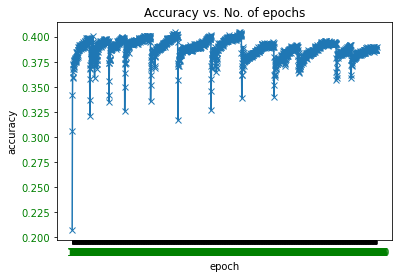

In [49]:
plot_accuracies(num_epochs, val_metrics)

In [50]:
def plot_losses(epoch, train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    x = np.arange(1, epoch+1, 1)
    
    plt.plot(x, train_losses, '-bx')
    plt.plot(x, val_losses, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

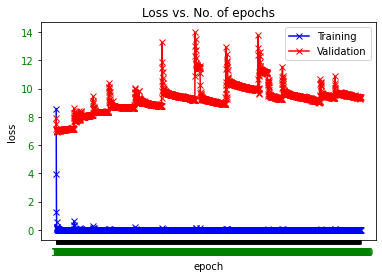

In [51]:
plot_losses(num_epochs, train_losses, val_losses)

In [52]:
result = evaluate(loaded_model, loss_Function, test_dl, accuracy)
result

(9.522354769688706, 1323, 0.3801965230536659)

In [53]:
torch.save(loaded_model.state_dict(), 'el_lfw_featExtr.pth')

In [54]:
# Creating a new data frame
newDataframe = pd.DataFrame()

newDataframe['Train Loss'] = train_losses
newDataframe['Val Loss'] = val_losses
newDataframe['Val Acc.'] = val_metrics

# Converting the data frame to an excel file
# newDataframe.to_excel('lfw_model_outputs.xlsx', sheet_name="Sheet 2", index = False)

with pd.ExcelWriter("lfw_model_outputs.xlsx", mode="a", engine="openpyxl") as writer:
    newDataframe.to_excel(writer, sheet_name="Sheet FE")

# Reading the data from the outputExcelFile
excelData = pd.read_excel('lfw_model_outputs.xlsx', sheet_name="Sheet FE")

#Printing the data frame
print(excelData)

      Unnamed: 0    Train Loss  Val Loss  Val Acc.
0              0  8.572921e+00  7.903751  0.207105
1              1  3.990205e+00  7.471876  0.305367
2              2  1.277602e+00  7.125047  0.341648
3              3  5.254039e-01  6.935993  0.359788
4              4  2.175915e-01  6.997904  0.358277
...          ...           ...       ...       ...
1995        1995  6.549960e-09  9.290730  0.386999
1996        1996  3.929976e-09  9.397646  0.386243
1997        1997  9.169944e-09  9.328924  0.386243
1998        1998  1.047994e-08  9.378066  0.386999
1999        1999  2.266265e-07  9.368464  0.390023

[2000 rows x 4 columns]


In [55]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#                 dataloader = train_dl
#             else:
#                 model.eval()   # Set model to evaluate mode
#                 dataloader = val_dl

#             len_input = 0
#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloader:
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 len_input += len(inputs)
#                 running_loss += loss.item() * len(inputs)
#                 running_corrects += torch.sum(preds == labels).item() / len(preds)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / len_input
#             epoch_acc = running_corrects / len_input

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [56]:
# criterion = F.cross_entropy

# # Observe that all parameters are being optimized
# optimizer_ft = torch.optim.SGD(loaded_model.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [57]:
# model_ft = train_model(loaded_model, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=10)